# Plant Seedlings Classification
- The goal of the competition is to create a classifier capable of determining a plant's species from a photo.
- [Plant Seedlings Classification], https://www.kaggle.com/c/plant-seedlings-classification/overview
- Train accuracy: 86.25%, Val accuracy: 80%
    
### Reference
- [coding-practice by osterburg], 'https://github.com/osterburg/coding-practice'    

## 0. Import Packages

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import tarfile
import glob
from six.moves import urllib
import random
import shutil
from PIL import Image
import imageio
from PIL import Image, ImageOps
# from scipy.misc import imresize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import load_model
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

## 1. Load Dataset
- Convert PNG to JPG

In [3]:
def convert_jpg(dir, save_dir):
    
    data = []
    cat_list = os.listdir(dir)
    cat_len = len(os.listdir(dir))
    
    for cat in cat_list :
        
        category = os.listdir(dir + cat)
        i = 0
        for name in category :
            png = imageio.imread(dir + cat + '/' + name)
            png = Image.fromarray(png)
            png.load()  # for splitting

            # convert RGBA to RGB -> alpha channel
            if(len(png.split()) == 4):
                img = Image.new('RGB', png.size, (255, 255, 255)) # white
                img.paste(png, mask = png.split()[3])
            else:
                img = png

            img.save(save_dir + cat + '/' + str(i) + '.jpg')
            i += 1

In [4]:
# dir = "train/"
# cat_list = os.listdir(dir)
# cat_len = len(os.listdir(dir))

# print("The number of category :",cat_len)
# print(cat_list)

The number of category : 12
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [5]:
# # Convert png to jpg
# dir = "train/"
# save_dir = "train_jpg/"
# convert_jpg(dir, save_dir)

## 2. Make Dataset

In [10]:
# params
batch_size = 32
num_classes = 12
epochs = 50

In [11]:
preprocessing_image = tf.keras.preprocessing.image

train_datagen = preprocessing_image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

val_datagen = preprocessing_image.ImageDataGenerator(rescale=1./255)

In [12]:
BASE_DIR = os.getcwd()

train_generator = train_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "train_jpg/train"),
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "train_jpg/validation"),
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode='categorical')

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


## 3. Resnet (Deep Residual Neural Network)
- Pre-activation Bottleneck Residual Block

In [13]:
models = tf.keras.models
layers = tf.keras.layers
initializers = tf.keras.initializers
regularizers = tf.keras.regularizers
losses = tf.keras.losses
optimizers = tf.keras.optimizers 
metrics = tf.keras.metrics

In [14]:
def residual_block(input_tensor, filters, stage, reg=0.0, use_shortcuts=True):

    bn_name = 'bn' + str(stage)
    conv_name = 'conv' + str(stage)
    relu_name = 'relu' + str(stage)
    merge_name = 'merge' + str(stage)

    # 1x1 conv
    # batchnorm-relu-conv
    # from input_filters to bottleneck_filters
    
    if stage>1: # first activation is just after conv1
        x = layers.BatchNormalization(name=bn_name+'a')(input_tensor)
        x = layers.Activation('relu', name=relu_name+'a')(x)
    else:
        x = input_tensor

    x = layers.Convolution2D(
            filters[0], (1,1),
            kernel_regularizer=regularizers.l2(reg),
            use_bias=False,
            name=conv_name+'a'
        )(x)

    # 3x3 conv
    # batchnorm-relu-conv
    # from bottleneck_filters to bottleneck_filters
    
    x = layers.BatchNormalization(name=bn_name+'b')(x)
    x = layers.Activation('relu', name=relu_name+'b')(x)
    x = layers.Convolution2D(
            filters[1], (3,3),
            padding='same',
            kernel_regularizer=regularizers.l2(reg),
            use_bias = False,
            name=conv_name+'b'
        )(x)

    # 1x1 conv
    # batchnorm-relu-conv
    # from bottleneck_filters  to input_filters
    
    x = layers.BatchNormalization(name=bn_name+'c')(x)
    x = layers.Activation('relu', name=relu_name+'c')(x)
    x = layers.Convolution2D(
            filters[2], (1,1),
            kernel_regularizer=regularizers.l2(reg),
            name=conv_name+'c'
        )(x)

    # merge output with input layer (residual connection)
    
    if use_shortcuts:
        x = layers.add([x, input_tensor], name=merge_name)

    return x

- Full Residual Network

In [15]:
def ResNetPreAct(input_shape=(32,32,3), nb_classes=5, num_stages=5,
                 use_final_conv=False, reg=0.0):


    # Input
    img_input = layers.Input(shape=input_shape)

    #### Input stream ####
    # conv-BN-relu-(pool)
    
    x = layers.Convolution2D(
            128, (3,3), strides=(2, 2),
            padding='same',
            kernel_regularizer=regularizers.l2(reg),
            use_bias=False,
            name='conv0'
        )(img_input)
    x = layers.BatchNormalization(name='bn0')(x)
    x = layers.Activation('relu', name='relu0')(x)
#     x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool0')(x)

    #### Residual Blocks ####
    # 1x1 conv: batchnorm-relu-conv
    # 3x3 conv: batchnorm-relu-conv
    # 1x1 conv: batchnorm-relu-conv
    
    for stage in range(1,num_stages+1):
        x = residual_block(x, [32,32,128], stage=stage, reg=reg)


    #### Output stream ####
    # BN-relu-(conv)-avgPool-softmax
    
    x = layers.BatchNormalization(name='bnF')(x)
    x = layers.Activation('relu', name='reluF')(x)

    # Optional final conv layer
    if use_final_conv:
        x = layers.Convolution2D(
                64, (3,3),
                padding='same',
                kernel_regularizer=regularizers.l2(reg),
                name='convF'
            )(x)

    pool_size = input_shape[0] / 2
    x = layers.AveragePooling2D((pool_size,pool_size),name='avg_pool')(x)

    x = layers.Flatten(name='flat')(x)
    x = layers.Dense(nb_classes, activation='softmax', name='fc10')(x)

    return models.Model(img_input, x, name='rnpa')

- Architecture

In [23]:
model = ResNetPreAct()
model.summary()

Model: "rnpa"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 128)  3456        input_5[0][0]                    
__________________________________________________________________________________________________
bn0 (BatchNormalization)        (None, 16, 16, 128)  512         conv0[0][0]                      
__________________________________________________________________________________________________
relu0 (Activation)              (None, 16, 16, 128)  0           bn0[0][0]                        
_______________________________________________________________________________________________

- Training

In [24]:
def compile_model(model):

    loss = losses.categorical_crossentropy

    optimizer = optimizers.Adam(lr=0.0001)

    metric = [metrics.categorical_accuracy, metrics.top_k_categorical_accuracy]

    model.compile(optimizer, loss, metric)

    return model

In [25]:
model = ResNetPreAct(input_shape=(32, 32, 3), nb_classes = num_classes , num_stages = 5,
                     use_final_conv=False, reg=0.005)

model = compile_model(model)

In [26]:
%%time
hist50 = model.fit_generator(
    train_generator,
    steps_per_epoch=3803//batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=20)

Epoch 1/50
100/100 [==============================] - 48s 485ms/step - loss: 5.6779 - categorical_accuracy: 0.1565 - top_k_categorical_accuracy: 0.5790 - val_loss: 5.6303 - val_categorical_accuracy: 0.1266 - val_top_k_categorical_accuracy: 0.4437
Epoch 2/50
100/100 [==============================] - 34s 340ms/step - loss: 5.1281 - categorical_accuracy: 0.3544 - top_k_categorical_accuracy: 0.7412 - val_loss: 5.4179 - val_categorical_accuracy: 0.1469 - val_top_k_categorical_accuracy: 0.4563
Epoch 3/50
100/100 [==============================] - 31s 313ms/step - loss: 4.6641 - categorical_accuracy: 0.4395 - top_k_categorical_accuracy: 0.8379 - val_loss: 5.4033 - val_categorical_accuracy: 0.1453 - val_top_k_categorical_accuracy: 0.4469
Epoch 4/50
100/100 [==============================] - 34s 335ms/step - loss: 4.2805 - categorical_accuracy: 0.5088 - top_k_categorical_accuracy: 0.9000 - val_loss: 5.3962 - val_categorical_accuracy: 0.1469 - val_top_k_categorical_accuracy: 0.4422
Epoch 5/50
1

Epoch 22/50
100/100 [==============================] - 32s 322ms/step - loss: 1.9477 - categorical_accuracy: 0.7947 - top_k_categorical_accuracy: 0.9897 - val_loss: 2.4156 - val_categorical_accuracy: 0.6375 - val_top_k_categorical_accuracy: 0.9656
Epoch 23/50
100/100 [==============================] - 32s 322ms/step - loss: 1.9147 - categorical_accuracy: 0.7934 - top_k_categorical_accuracy: 0.9887 - val_loss: 2.2883 - val_categorical_accuracy: 0.6547 - val_top_k_categorical_accuracy: 0.9672
Epoch 24/50
100/100 [==============================] - 32s 320ms/step - loss: 1.8633 - categorical_accuracy: 0.8019 - top_k_categorical_accuracy: 0.9925 - val_loss: 2.0346 - val_categorical_accuracy: 0.7422 - val_top_k_categorical_accuracy: 0.9766
Epoch 25/50
100/100 [==============================] - 32s 322ms/step - loss: 1.8050 - categorical_accuracy: 0.8131 - top_k_categorical_accuracy: 0.9915 - val_loss: 2.1141 - val_categorical_accuracy: 0.7094 - val_top_k_categorical_accuracy: 0.9547
Epoch 26

## 4. Accuracy and Loss Analysis

In [27]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))

    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('SqueezeNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('SqueezeNet loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.show()

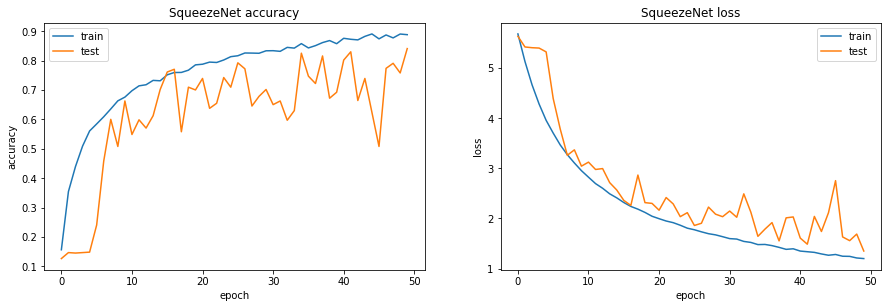

In [28]:
plot_accuracy_and_loss(hist50)

In [34]:
print("-- Evaluate --")

scores_train = model.evaluate_generator(
            train_generator, 
            steps = 5)
scores_val = model.evaluate_generator(
            validation_generator, 
            steps = 5)

print("Train %s: %.2f%%" %(model.metrics_names[1], scores_train[1]*100))
print("Val %s: %.2f%%" %(model.metrics_names[1], scores_val[1]*100))

print("-- Predict --")
output_train = model.predict_generator(train_generator, steps=5)
output_val = model.predict_generator(validation_generator, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

print(train_generator.class_indices)
print(output_train)

print(validation_generator.class_indices)
print(output_val)

-- Evaluate --
Train categorical_accuracy: 86.25%
Val categorical_accuracy: 80.00%
-- Predict --
{'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}
[[0.000 0.016 0.007 ... 0.031 0.037 0.727]
 [0.012 0.003 0.005 ... 0.126 0.006 0.013]
 [0.024 0.000 0.000 ... 0.000 0.000 0.000]
 ...
 [0.000 0.001 0.000 ... 0.387 0.003 0.000]
 [0.604 0.000 0.002 ... 0.000 0.000 0.002]
 [0.000 0.957 0.020 ... 0.005 0.005 0.000]]
{'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}
[[0.000 0.000 0.000 ... 0.000 0.000 0.000]
 [0.001 0.025 0.521 ... 0.012 0.412 0.002]
 [0.200 0.000 0.004 ... 0.002 0.000 0.007]
 ...
 [0.112 0.000 0.008 ... 0.000 0

## 5. Save weights and model architecture

In [35]:
# save model architecture
model_json = model.to_json()
open('Resnet_model_with_50iterations.json', 'w').write(model_json)

# save model's learned weights
model.save_weights('Resnet_weights_with_50iterations.h5', overwrite=True)

In [37]:
# Load trained model
import tensorflow as tf
from tensorflow.keras.models import model_from_json 
from tensorflow.keras.models import load_model

json_file = open("Resnet_model_with_50iterations.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)
 
# model weight load 
loaded_model.load_weights("Resnet_weights_with_50iterations.h5")
print("Loaded model from disk")

Loaded model from disk


## 6. Submission

In [38]:
z = glob.glob('test/*.png')
test_imgs = []
names = []
for fn in z:
    if fn[-3:] != 'png':
        continue
    names.append(fn.split('test\\')[-1])
#     print(names)
    new_img = Image.open(fn)
    test_img = ImageOps.fit(new_img, (32,32), Image.ANTIALIAS).convert('RGB')
    test_imgs.append(test_img)

In [39]:
test_img = np.array([np.array(im) for im in test_imgs])
test_x = test_img.reshape(test_img.shape[0], 32, 32, 3) / 255

test_x.shape

(794, 32, 32, 3)

In [48]:
lb = LabelBinarizer().fit(names)

pred = model.predict(test_x)
# print(pred)
prediction = lb.inverse_transform(pred)

In [55]:
pred[0,:].shape

(12,)

In [58]:
class_pred = []
for i in range(len(prediction)) :
    class_pred.append(cat_list[np.argmax(pred[i,:])])

In [61]:
np.shape(class_pred)

(794,)

In [62]:
df = pd.DataFrame(data={'file': names, 'species': class_pred})
df_sort = df.sort_values(by=['file'])
df_sort.to_csv('Resnet_with_50iterations.csv', index=False)